In [ ]:
!pip install catboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
import catboost
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_filtered_with_ids = pd.read_pickle("/content/drive/MyDrive/Other/corrected_data1.pkl")

In [ ]:
cb_model = CatBoostClassifier(random_seed=42, eval_metric='AUC', subsample=1)

In [ ]:
data_filtered_with_ids["target"] = data_filtered_with_ids["conversions"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
data_filtered_with_ids["date_time"].min(), data_filtered_with_ids["date_time"].max()

('2016-09-02 01:00:00', '2016-09-16 04:00:00')

In [ ]:
cols_to_use = list(data_filtered_with_ids.columns)

In [ ]:
cols_to_use.remove("date_time")
cols_to_use.remove("conversions")
cols_to_use.remove("impressions")


In [ ]:
train_df = data_filtered_with_ids.loc[data_filtered_with_ids["date_time"] < "2016-09-14", cols_to_use]
valid_df = data_filtered_with_ids.loc[data_filtered_with_ids["date_time"] > "2016-09-14", cols_to_use]

In [ ]:
categorical_cols = ["banner_id", "advertiser_id", "offer_id", "zone_id", "affiliate_id", "geo", "region_code", "city_code",
                    "os_type", "os", "os_version", "device_type", "device", "browser", "lang", "isp", "mobile_isp",
                    "proxy", "netspeed", "day_of_week", "hour"]
nums_cols = ["varp", "varcc", "varpp"]

In [ ]:
for colname in categorical_cols:
    train_df[colname] = train_df[colname].astype(str)
    valid_df[colname] = valid_df[colname].astype(str)

In [ ]:
train_df["target"].value_counts()

0    814493
1      2622
Name: target, dtype: int64

In [ ]:
valid_df["target"].value_counts()

0    126956
1       413
Name: target, dtype: int64

In [ ]:
train_cols = categorical_cols + nums_cols

In [ ]:
# в зависимости от CTR проставляем вес целевому признакоу
train_df["weight"] = train_df["CTR"].apply(lambda x: x if x > 0 else 1)
valid_df["weight"] = valid_df["CTR"].apply(lambda x: x if x > 0 else 1)

In [ ]:
valid_df["weight"].value_counts()

1.000000    127064
0.500000       244
0.333333        26
0.250000        10
0.200000         7
0.166667         6
0.125000         2
0.074074         1
0.013514         1
0.100000         1
0.038462         1
0.028846         1
0.020408         1
0.142857         1
0.033333         1
0.057851         1
0.013889         1
Name: weight, dtype: int64

In [ ]:
train_pool = catboost.Pool(data=train_df[train_cols], label=train_df["target"],
                           cat_features=categorical_cols, weight=train_df["weight"] * 10)
valid_pool = catboost.Pool(data=valid_df[train_cols], label=valid_df["target"],
                           cat_features=categorical_cols, weight=valid_df["weight"] * 10)

In [ ]:
cb_model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=50)

Learning rate set to 0.166052
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.64s	remaining: 43m 58s
50:	test: 0.7792909	best: 0.7798377 (46)	total: 3m 4s	remaining: 57m 17s
100:	test: 0.7792251	best: 0.7843943 (64)	total: 6m 35s	remaining: 58m 40s
150:	test: 0.7764848	best: 0.7843943 (64)	total: 10m 33s	remaining: 59m 21s
200:	test: 0.7765878	best: 0.7843943 (64)	total: 14m 44s	remaining: 58m 34s
250:	test: 0.7760592	best: 0.7843943 (64)	total: 18m 36s	remaining: 55m 31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7843942921
bestIteration = 64

Shrink model to first 65 iterations.


In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(valid_df[train_cols])

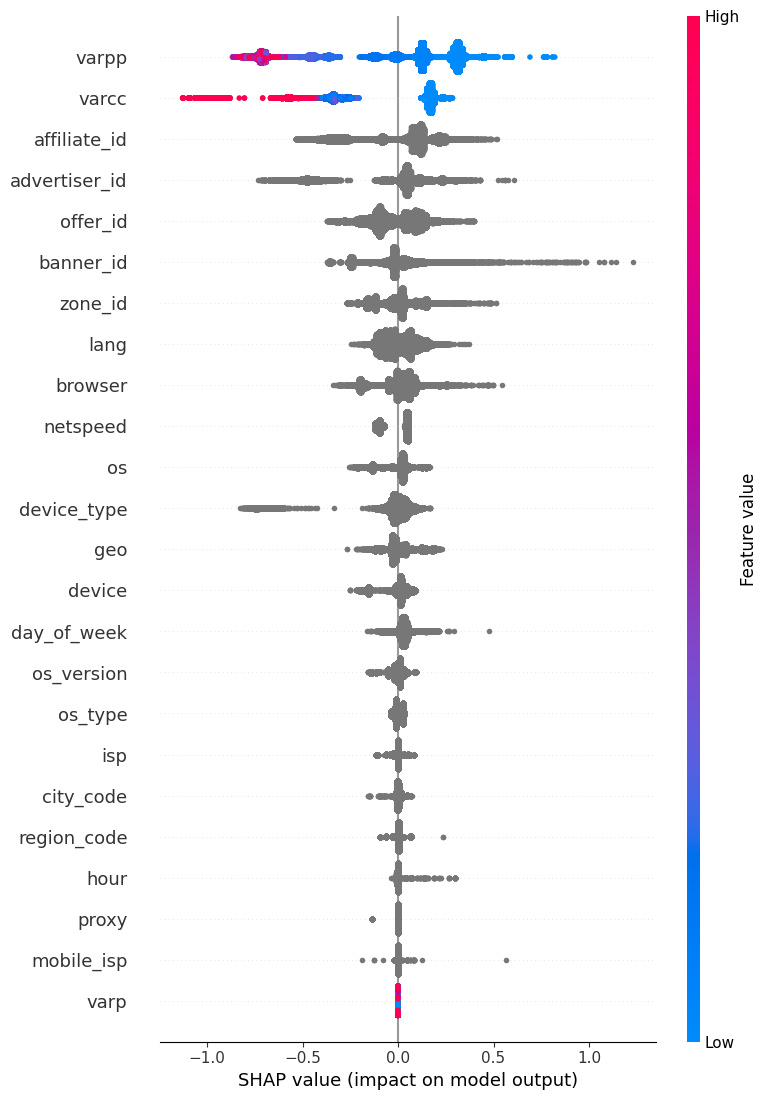

In [ ]:
shap.summary_plot(shap_values, valid_df[train_cols], max_display=len(train_cols))

In [ ]:
feature_importances = pd.DataFrame(cb_model.feature_importances_, index=cb_model.feature_names_, columns=["importance"])
feature_importances.sort_values("importance", ascending=False)

,importance
varpp,18.758282
varcc,15.073095
advertiser_id,11.090337
offer_id,9.553090
affiliate_id,8.317091
device_type,6.182211
browser,4.688931
lang,4.501209
banner_id,3.684075
zone_id,3.624428
